In [1]:
import os
import json
import re
import statistics
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import date

# ------------------------------------------------------------------#
# 1. Konfiguration: Cafeterias, Datei-Pfad und Regex
# ------------------------------------------------------------------#
cafeterias = {
    "Mensa Leopoldstr.": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_411_-de.html",
    "Mensa Arcisstr.": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_421_-de.html",
    "Mensa Weihenstephan": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_423_-de.html",
    "Mensa Garching": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_422_-de.html",
    "StuBistro Garching": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_426_-de.html",
    "StuBistro WST Akademie": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_456_-de.html",
    "StuBistro Olympiacampus": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_425_-de.html",
    "StuBistro BEP": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_451_-de.html",
    "StuBistro Arcisstr.": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_450_-de.html",
    "StuBistro Goethestr.": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_418_-de.html",
    "StuBistro Schellingstr.": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_416_-de.html",
    "StuBistro Adalbertstr.": "https://www.studierendenwerk-muenchen-oberbayern.de/mensa/speiseplan/speiseplan_452_-de.html",
    # Weitere Mensa- oder Cafeteria-URLs hier ergänzen
}

# Name der JSON-Datei, in der alle Daten gesammelt werden
DATA_FILE = "cafeteria_emissions.json"

# ------------------------------------------------------------------#
# 2. Hilfsfunktion: CO₂-Daten aus <li>-Elementen extrahieren
# ------------------------------------------------------------------#
def extract_emissions_from_items(meal_items):
    """
    Extrahiert aus einer Liste von <li class="c-menu-dish-list__item">-Elementen
    pro Kategorie alle CO₂-Werte und gibt ein Dictionary zurück:
        { Kategorie (str) : [co2_wert_1, co2_wert_2, ...] }
    """
    emissions = {}
    for item in meal_items:
        # (a) Kategorie aus <span class="stwm-artname">
        cat_span = item.find("span", class_="stwm-artname")
        category = cat_span.get_text(strip=True) if cat_span else "Sonstiges"

        # (b) CO₂-Wert aus dem Attribut data-essen-co2-wert
        co2_str = item.get("data-essen-co2-wert", "").strip()
        if not co2_str:
            continue
        try:
            co2_value = float(co2_str.replace(",", "."))
        except ValueError:
            continue

        emissions.setdefault(category, []).append(co2_value)

    return emissions

# ------------------------------------------------------------------#
# 3. Hilfsfunktionen: Zusammenfassung und Gesamtmittel berechnen
# ------------------------------------------------------------------#
def summarize_categories(emissions_dict):
    """
    Erstellt aus einem Dictionary {Kategorie: [co2_werte]} einen Dictionary
    mit den kategoriespezifischen Zusammenfassungen:
        { Kategorie: {"n_meals": int, "avg_co2": float}, ... }
    """
    summary = {}
    for category, values in emissions_dict.items():
        n_meals = len(values)
        avg_co2 = round(statistics.fmean(values), 1)
        summary[category] = {
            "n_meals": n_meals,
            "avg_co2": avg_co2
        }
    return summary

def calculate_overall_average_from_emissions(emissions_dict):
    """
    Berechnet das arithmetisches Mittel über alle Einzelwerte aus einem 
    Dictionary {Kategorie: [co2_werte]}. Gibt None zurück, falls keine Daten.
    """
    all_values = [val for sublist in emissions_dict.values() for val in sublist]
    return round(statistics.fmean(all_values), 1)

# ------------------------------------------------------------------#
# 4. Hauptlogik zur Datengewinnung pro Cafeteria
# ------------------------------------------------------------------#
def fetch_cafeteria_data(url):
    """
    Lädt den Speiseplan von der gegebenen URL herunter und gibt ein Dictionary
    zurück, dessen Schlüssel Datums-Strings im Format "DD.MM.YYYY" sind und
    dessen Werte wiederum Dictionaries enthalten mit
      - "categories": kategoriespezifische Zusammenfassung,
      - "overall_avg": Gesamtmittel für dieses Datum.
    Falls keine datenbezogenen Abschnitte gefunden werden, wird ein leeres Dict zurückgegeben.
    """
    result = {}
    response = requests.get(url, timeout=10)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")

    # Selektiere alle <div class="c-schedule__item">-Blöcke
    schedule_items = soup.select("div.c-schedule__item")
    if not schedule_items:
        return result

    for block in schedule_items:
        header_div = block.find("div", class_=re.compile(r"c-schedule__header"))

        strong_tag = header_div.find("strong")

        date_str = strong_tag.get_text(strip=True)  # z.B. "02.06.2025"

        menu_list = block.find("ul", class_="c-menu-dish-list")

        meal_items = menu_list.select("li.c-menu-dish-list__item")

        # CO₂-Werte nach Kategorie extrahieren
        emissions_dict = extract_emissions_from_items(meal_items)

        # Kategoriespezifische Zusammenfassung und Gesamtmittel berechnen
        categories_summary = summarize_categories(emissions_dict)
        overall_avg = calculate_overall_average_from_emissions(emissions_dict)

        result[date_str] = {
            "categories": categories_summary,
            "overall_avg": overall_avg
        }

    return result

# ------------------------------------------------------------------#
# 5. Laden vorhandener Daten oder Erzeugen neuer Struktur
# ------------------------------------------------------------------#
if os.path.exists(DATA_FILE):
    with open(DATA_FILE, "r", encoding="utf-8") as f:
        all_data = json.load(f)
else:
    # Wenn Datei nicht existiert, legen wir leeres Grundgerüst an
    all_data = {caf_name: {} for caf_name in cafeterias.keys()}

# ------------------------------------------------------------------#
# 6. Abgleich und Aktualisierung der Datenbank
# ------------------------------------------------------------------#
updated = False  # Flag, um festzustellen, ob wir etwas hinzugefügt haben

for caf_name, url in cafeterias.items():
    try:
        print(f"Abrufen und Verarbeiten: {caf_name}")
        new_data = fetch_cafeteria_data(url)
    except Exception as e:
        print(f"  Fehler beim Abrufen von {caf_name}: {e}")
        continue

    # Bestehende Daten dieser Cafeteria
    existing_dates = set(all_data.get(caf_name, {}).keys())

    for date_str, info in new_data.items():
        if date_str not in existing_dates:
            # Neu hinzugefügtes Datum → in den Datensatz übernehmen
            all_data.setdefault(caf_name, {})[date_str] = info
            print(f"  Datum hinzugefügt: {date_str} ({caf_name})")
            updated = True

# ------------------------------------------------------------------#
# 7. Speichern, falls sich etwas geändert hat
# ------------------------------------------------------------------#
if updated:
    with open(DATA_FILE, "w", encoding="utf-8") as f:
        json.dump(all_data, f, ensure_ascii=False, indent=2)
    print(f"\nAlle neuen Daten wurden in '{DATA_FILE}' gespeichert.")
else:
    print("\nKeine neuen Daten gefunden. Datei wurde nicht verändert.")

Abrufen und Verarbeiten: Mensa Leopoldstr.
  Fehler beim Abrufen von Mensa Leopoldstr.: fmean requires at least one data point
Abrufen und Verarbeiten: Mensa Arcisstr.
  Datum hinzugefügt: 07.01.2026 (Mensa Arcisstr.)
  Datum hinzugefügt: 08.01.2026 (Mensa Arcisstr.)
  Datum hinzugefügt: 09.01.2026 (Mensa Arcisstr.)
Abrufen und Verarbeiten: Mensa Weihenstephan
  Datum hinzugefügt: 07.01.2026 (Mensa Weihenstephan)
  Datum hinzugefügt: 08.01.2026 (Mensa Weihenstephan)
  Datum hinzugefügt: 09.01.2026 (Mensa Weihenstephan)
Abrufen und Verarbeiten: Mensa Garching
  Datum hinzugefügt: 07.01.2026 (Mensa Garching)
  Datum hinzugefügt: 08.01.2026 (Mensa Garching)
  Datum hinzugefügt: 09.01.2026 (Mensa Garching)
Abrufen und Verarbeiten: StuBistro Garching
  Fehler beim Abrufen von StuBistro Garching: fmean requires at least one data point
Abrufen und Verarbeiten: StuBistro WST Akademie
  Datum hinzugefügt: 07.01.2026 (StuBistro WST Akademie)
  Datum hinzugefügt: 08.01.2026 (StuBistro WST Akademi

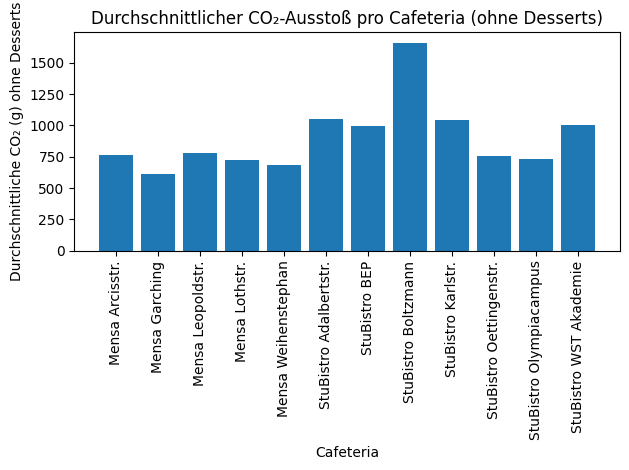

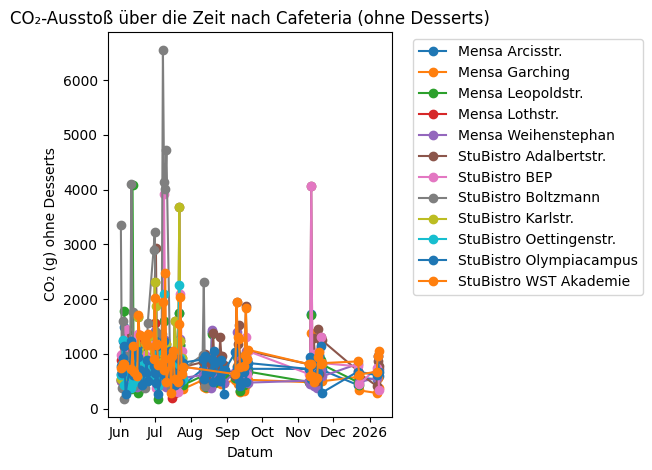


Durchschnittliche Emission pro Cafeteria (ohne Desserts):
| cafeteria               |   avg_emissions |
|-------------------------|-----------------|
| Mensa Arcisstr.         |         760.417 |
| Mensa Garching          |         614.168 |
| Mensa Leopoldstr.       |         777.846 |
| Mensa Lothstr.          |         724.305 |
| Mensa Weihenstephan     |         684.627 |
| StuBistro Adalbertstr.  |        1051.96  |
| StuBistro BEP           |         994.461 |
| StuBistro Boltzmann     |        1659.26  |
| StuBistro Karlstr.      |        1046.55  |
| StuBistro Oettingenstr. |         758.933 |
| StuBistro Olympiacampus |         735.223 |
| StuBistro WST Akademie  |        1000.4   |


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tabulate import tabulate
from datetime import datetime

# ------------------------------------------------------------------#
# 1. JSON-Datei laden und DataFrame erstellen (ohne Desserts)
# ------------------------------------------------------------------#
DATA_FILE = "cafeteria_emissions.json"
with open(DATA_FILE, "r", encoding="utf-8") as f:
    all_data = json.load(f)

cetegories_to_be_removed_from_computation = {
    "dessert",
    "süßspeise",
    "SÃ¼Ã\x9fspeise",
    "suesse",
    "sua",
    "süß",
    "suss",
    "sweeter",
    "Brot",
    "Obst",
    "Brot/Obst",
    "Tagessupe, Brot, Obst",
    "Tagessuppe, Brot, Obst",
    "<no name>"
}

normalized_categories_to_remove = {term.casefold() for term in cetegories_to_be_removed_from_computation}

def category_not_relevant(name: str) -> bool:
    text = name.casefold()
    return any(term in text for term in normalized_categories_to_remove)

records = []
for cafeteria, dates in all_data.items():
    for date_str, info in dates.items():
        dt = datetime.strptime(date_str, "%d.%m.%Y")
        categories = info.get("categories", {})

        total_sum = 0.0
        total_count = 0
        for cat, vals in categories.items():
            if category_not_relevant(cat) or vals["avg_co2"] == 0:
                continue
            n = vals["n_meals"]
            avg = vals["avg_co2"]
            total_sum += avg * n
            total_count += n
        if total_count == 0:
            overall_emissions = None
        else:
            overall_emissions = (total_sum / total_count)

        records.append({
            "cafeteria": cafeteria,
            "date": dt,
            "overall_emissions": overall_emissions
        })

df_emissions = pd.DataFrame(records).sort_values(["cafeteria", "date"])
df_emissions = df_emissions.dropna(subset=["overall_emissions"])

# ------------------------------------------------------------------#
# 2. Metriken berechnen (ohne Desserts)
# ------------------------------------------------------------------#
avg_by_cafeteria_emissions = (
    df_emissions
    .groupby("cafeteria")["overall_emissions"]
    .mean()
    .reset_index()
)

range_by_date_emissions = (
    df_emissions
    .groupby("date")["overall_emissions"]
    .agg(lambda x: x.max() - x.min())
    .reset_index()
    .rename(columns={"overall_emissions": "emission_range_emissions"})
)

# ------------------------------------------------------------------#
# 3. Visualisierungen (ohne Desserts)
# ------------------------------------------------------------------#
# 3.1 Balkendiagramm
plt.figure()
plt.bar(avg_by_cafeteria_emissions["cafeteria"], avg_by_cafeteria_emissions["overall_emissions"])
plt.xticks(rotation=90)
plt.xlabel("Cafeteria")
plt.ylabel("Durchschnittliche CO₂ (g) ohne Desserts")
plt.title("Durchschnittlicher CO₂-Ausstoß pro Cafeteria (ohne Desserts)")
plt.tight_layout()
plt.show()

# 3.2 Liniendiagramm: CO₂-Ausstoß über die Zeit je Cafeteria (ohne Desserts)
plt.figure()
ax = plt.gca()
for cafeteria_name, group in df_emissions.groupby("cafeteria"):
    ax.plot(group["date"], group["overall_emissions"], marker="o", label=cafeteria_name)

ax.set_xlabel("Datum")
ax.set_ylabel("CO₂ (g) ohne Desserts")
ax.set_title("CO₂-Ausstoß über die Zeit nach Cafeteria (ohne Desserts)")

# Datumslocators und Formatter einstellen, damit die Datumsbeschriftungen nicht überlappen
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------#
# 4. Tabellarische Ausgabe mit tabulate (ohne Desserts)
# ------------------------------------------------------------------#
print("\nDurchschnittliche Emission pro Cafeteria (ohne Desserts):")
print(tabulate(
    avg_by_cafeteria_emissions.rename(columns={"overall_emissions": "avg_emissions"}), 
    headers="keys", 
    tablefmt="github", 
    showindex=False
))

In [8]:
# ------------------------------------------------------------------#
# 6. Bestimmen des Reduktionspotenzials
# ------------------------------------------------------------------#
from collections import defaultdict

meals = []
for mensa, days in all_data.items():
    for date, overview in days.items():
        for name, stats in overview.get("categories", {}).items():
            avg_co2 = stats.get("avg_co2")
            if avg_co2 is None or avg_co2 == 0.0:
                continue
            meals.append(
                {
                    "mensa": mensa,
                    "date": date,
                    "name": name.strip() or "<no name>",
                    "avg_co2": avg_co2,
                    "n_meals": stats.get("n_meals", 1),
                }
            )

if not meals:
    raise SystemExit("no meals found in the dataset")

meals = [meal for meal in meals if not category_not_relevant(meal["name"])]

total_servings = sum(meal["n_meals"] for meal in meals)
average_co2 = (
    sum(meal["avg_co2"] * meal["n_meals"] for meal in meals) / total_servings
)

remove_ratio = 1/4
servings_to_remove = total_servings * remove_ratio
meals_sorted = sorted(meals, key=lambda meal: meal["avg_co2"], reverse=True)

removed_servings = 0
cut_index = 0
while cut_index < len(meals_sorted) and removed_servings < servings_to_remove:
    removed_servings += meals_sorted[cut_index]["n_meals"]
    cut_index += 1

kept_meals = meals_sorted[cut_index:]
kept_servings = sum(meal["n_meals"] for meal in kept_meals)

remaining_percentage = (kept_servings / total_servings) * 100
remaining_avg = (
    sum(meal["avg_co2"] * meal["n_meals"] for meal in kept_meals) / kept_servings
)
reduction_potential = 1 - remaining_avg / average_co2

print(
    f"Die emissionstechnisch unteren {(1 - remove_ratio) * 100:.0f}% der gerichte "
    f"emittieren durschnittlich {remaining_avg:.1f} g CO2"
)
print(f"Bisheriger durschnitt CO2: {average_co2:.1f}")
print(f"Reduktionspotenzial: {reduction_potential * 100:.1f}%")
print()

# --- UPDATED: category percentages instead of just names ---
servings_per_category = defaultdict(float)
for meal in kept_meals:
    servings_per_category[meal["name"]] += meal.get("n_meals", 1)

print("Behaltene Kategorien (Anteil an den verbleibenden Portionen):")
for category, servings in sorted(
    servings_per_category.items(),
    key=lambda x: x[1],
    reverse=True,
):
    pct = 100 * servings / kept_servings if kept_servings else 0.0
    print(f"- {category}: {pct:.1f}% ({int(servings)} von {int(kept_servings)})")

Die emissionstechnisch unteren 75% der gerichte emittieren durschnittlich 458.0 g CO2
Bisheriger durschnitt CO2: 833.2
Reduktionspotenzial: 45.0%

Behaltene Kategorien (Anteil an den verbleibenden Portionen):
- Pasta: 21.1% (372 von 1761)
- Studitopf: 14.2% (250 von 1761)
- Vegetarisch/fleischlos: 10.6% (186 von 1761)
- Wok: 8.9% (156 von 1761)
- Vegan: 8.7% (154 von 1761)
- Grill: 6.9% (121 von 1761)
- Aktionsessen 7: 6.1% (107 von 1761)
- Fleisch: 4.8% (85 von 1761)
- Tagesgericht 1: 3.8% (67 von 1761)
- Aktionsessen 5: 3.5% (62 von 1761)
- Fisch: 2.6% (46 von 1761)
- StudiTopf: 2.2% (39 von 1761)
- Gericht 2: 1.9% (33 von 1761)
- Aktionsessen 8: 1.8% (32 von 1761)
- Pizza: 1.1% (20 von 1761)
- Gericht 1: 0.9% (15 von 1761)
- Gericht 3: 0.5% (9 von 1761)
- Pizza Veggie: 0.2% (4 von 1761)
- Aktionsessen 9: 0.1% (2 von 1761)
- Aktionsessen 6: 0.1% (1 von 1761)


Ca. 25k gäste in der Mensa pro tag. Angenommen davon 10k von der TUM und jedes gericht wird gleichhäufig genommen => Emissionen pro tag sind (kilo CO₂)

In [9]:
emissionen_pro_tag_von_tum_kilo = round(average_co2*10000)/1000
print(emissionen_pro_tag_von_tum_kilo)

8332.358


Das sind pro Jahr (Angenommen Mensa ist für 4 Wochen geschlossen)

In [10]:
emissionen_pro_jahr_tonnen = emissionen_pro_tag_von_tum_kilo * 5 * 48/1000 #angenommen mensa ist für vier wochen geschlossen (gleicht auch tage mit weniger gästen aus)
print(round(emissionen_pro_jahr_tonnen))

2000


Reduktionspotential (obere 1/4 der emissionsreichsten gerichte streichen):

In [11]:
reduktionspotential_pro_jahr_tonnen = emissionen_pro_jahr_tonnen * reduction_potential
print(round(reduktionspotential_pro_jahr_tonnen))

901
